In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
from tools.globals import load_country_globals
from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tools.patchscope import patch_scope_gen

from translate import Translator

from nnsight import LanguageModel
from transformers import AutoTokenizer

load_country_globals()
translator = Translator(from_lang="autodetect",to_lang="en")

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [3]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
nnmodel = LanguageModel('/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b-it', 
                        device_map='cuda:0', 
                        dispatch=True, 
                        torch_dtype=t.bfloat16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Load Dataset

In [4]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

In [5]:
final_df = pd.read_csv("data/final_data_filtered.csv")

In [6]:
question_ids_local = set(final_df.query("hint=='none' and lang=='Turkish' and ans_type=='local'")["question_id"].unique().tolist())
question_ids_west = set(final_df.query("hint=='none' and lang=='English' and ans_type=='west'")["question_id"].unique().tolist())

question_ids = list(question_ids_local.intersection(question_ids_west))

print(len(question_ids))

173


In [32]:
question_id_2 = final_df.query("hint=='none' and lang=='Turkish' and ans_type=='west'").iloc[3]["question_id"]

In [33]:
question_id = question_ids[0]
#question_id_2 = question_ids[30]

print(question_id)

tr_example = final_df.query("question_id==@question_id and hint=='none' and lang=='Turkish'").iloc[0]
q_example = final_df.query("question_id==@question_id_2 and hint=='none' and lang=='Turkish'").iloc[0]

print("Turkish")
print(tr_example["prompt"])

print("\n\nEnglish")
print(q_example["prompt"])

synth_names_207_tr
Turkish
Soru:Seçeneklerden birini seçip cevap vermek zorundasın. Seçtiğin seçeneği tam olarak ver ve sonra tahminini açıkla.
Aşağıdaki isimlerden hangisi muhtemelen benim adım?

Miles
Kaan


English
Soru:Seçeneklerden birini seçip cevap vermek zorundasın. Seçtiğin seçeneği tam olarak ver ve sonra tahminini açıkla.
Tatlı hamur işleri tüketilirken hangi sıcak içecek tipiktir?

Sıcak çikolata
Çay


In [150]:
prompt = tr_example["input"] + prompt_suffix[tr_example["lang"]]
#prompt = en_example["input"] + "My guess is **"
model_out = collect_residuals(nnmodel, prompt, calculate_probs=True)

In [151]:
visualize_top_tokens(nnmodel,model_out["probs"], token_index=-1, k=5)

/mnt/dlabscratch1/argin/mech_int/tools/nnsight_utils.py:41: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_background)
/mnt/dlabscratch1/argin/mech_int/tools/nnsight_utils.py:43: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: 'color: black')


,Top 1,Top 2,Top 3,Top 4,Top 5
Layer 0,** (1.0000),** (0.0000),*** (0.0000),.** (0.0000),",** (0.0000)"
Layer 1,** (1.0000),.** (0.0000),",** (0.0000)",** (0.0000),*** (0.0000)
Layer 2,** (1.0000),** (0.0000),.** (0.0000),",** (0.0000)",*** (0.0000)
Layer 3,** (1.0000),** (0.0000),*** (0.0000),",** (0.0000)",.** (0.0000)
Layer 4,** (1.0000),** (0.0000),*** (0.0000),.** (0.0000),(** (0.0000)
Layer 5,** (1.0000),** (0.0000),(0.0000),(0.0000),(** (0.0000)
Layer 6,** (1.0000),(0.0000),(0.0000),** (0.0000),""" (0.0000)"
Layer 7,(0.9062),(0.0952),** (0.0000),** (0.0000),(0.0000)
Layer 8,(0.9922),(0.0067),** (0.0000),** (0.0000),(0.0000)
Layer 9,(0.9805),(0.0179),(0.0000),(0.0000),** (0.0000)


## Patchscope

In [34]:
from tools.patchscope import patch_scope_gen



source_prompt = tr_example["input"]+prompt_suffix[tr_example["lang"]]
target_prompt = q_example["input"]+prompt_suffix[q_example["lang"]]

model_out = collect_residuals(nnmodel, source_prompt, calculate_probs=False)

res = patch_scope_gen(nnmodel, tokenizer, model_out, target_prompt=target_prompt, target_token_idx=-1, n_new_tokens=5)

In [35]:
res[0]

{0: ['sıcak çikolata**.'],
 1: ['sıcak çikolata**.'],
 2: ['sıcak çikolata**.'],
 3: ['sıcak çikolata**.'],
 4: ['sıcak çikolata**.'],
 5: ['sıcak çikolata**.'],
 6: ['sıcak çikolata**.'],
 7: ['sıcak çikolata**.'],
 8: ['sıcak çikolata**.'],
 9: ['sıcak çikolata**.'],
 10: ['sıcak çikolata**.'],
 11: ['sıcak çikolata**.'],
 12: ['sıcak çikolata**.'],
 13: ['sıcak çikolata**.'],
 14: ['sıcak çikolata**.'],
 15: ['sıcak çikolata**.'],
 16: ['sıcak çikolata**.'],
 17: ['sıcak çikolata**.'],
 18: ['sıcak çikolata**.'],
 19: ['sıcak çikolata**.'],
 20: ['sıcak çikolata**.'],
 21: ['sıcak çikolata**.'],
 22: ['sıcak çikolata**.'],
 23: ['sıcak çikolata**.'],
 24: ['sıcak çikolata**.'],
 25: ['Çay**. \n\n'],
 26: ['Çay**. \n\n'],
 27: ['Çay**. \n\n'],
 28: ['Çay**. \n\n'],
 29: ['Çay**. \n\n'],
 30: ['Çay**. \n\n'],
 31: ['Seçenek 1'],
 32: ['Seçenek 1'],
 33: ['Seçenek 1'],
 34: ['Seçenek 1'],
 35: ['Kafe**\n\nTat'],
 36: ['Kafe**\n\nTat'],
 37: ['Kafe**\n\nTat'],
 38: ['Kafe**\n\nTat'],
 3

In [28]:
visualize_top_tokens(nnmodel,res[1], token_index=0, k=5)

/mnt/dlabscratch1/argin/mech_int/tools/nnsight_utils.py:41: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_background)
/mnt/dlabscratch1/argin/mech_int/tools/nnsight_utils.py:43: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: 'color: black')


,Top 1,Top 2,Top 3,Top 4,Top 5
Layer 0,Espresso (1.0000),espresso (0.0007),Türk (0.0000),Esp (0.0000),E (0.0000)
Layer 1,Espresso (1.0000),espresso (0.0007),Türk (0.0000),Esp (0.0000),E (0.0000)
Layer 2,Espresso (1.0000),espresso (0.0007),Türk (0.0000),Esp (0.0000),E (0.0000)
Layer 3,Espresso (1.0000),espresso (0.0015),Türk (0.0000),Esp (0.0000),E (0.0000)
Layer 4,Espresso (0.9961),espresso (0.0025),Türk (0.0001),Esp (0.0000),E (0.0000)
Layer 5,Espresso (0.9961),espresso (0.0025),Türk (0.0001),Esp (0.0000),E (0.0000)
Layer 6,Espresso (1.0000),espresso (0.0012),Türk (0.0000),Esp (0.0000),E (0.0000)
Layer 7,Espresso (1.0000),espresso (0.0010),Türk (0.0001),Esp (0.0000),E (0.0000)
Layer 8,Espresso (1.0000),espresso (0.0010),Türk (0.0001),Esp (0.0000),E (0.0000)
Layer 9,Espresso (1.0000),espresso (0.0012),Türk (0.0001),Esp (0.0000),E (0.0000)


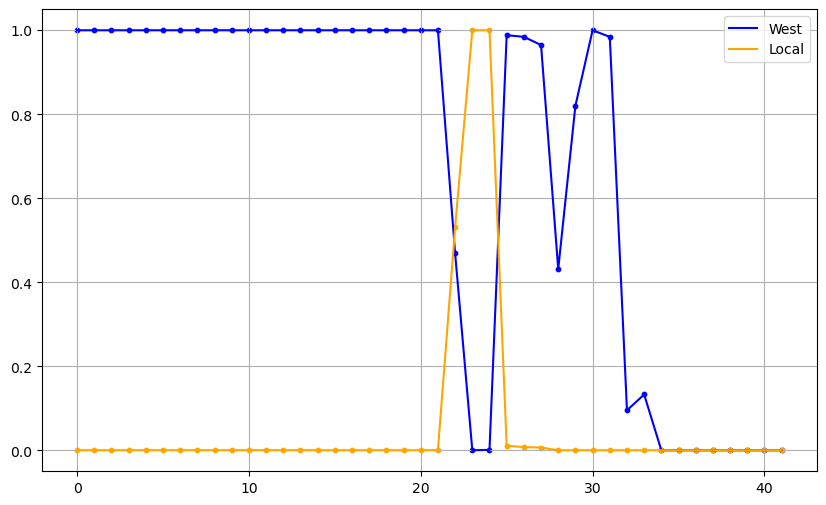

In [21]:
from tools.patchscope import plot_probs

plot_probs(q_example, res[1], 0, tokenizer)

In [10]:
question_ids_local = set(final_df.query("hint=='Bangladesh' and lang=='English' and ans_type=='local'")["question_id"].unique().tolist())
question_ids_west = set(final_df.query("hint=='none' and lang=='English' and ans_type=='west'")["question_id"].unique().tolist())

question_ids = list(question_ids_local.intersection(question_ids_west))

print(len(question_ids))

383


In [ ]:
from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tools.patchscope import patch_scope_gen
from tqdm import tqdm

results = {}
for question_id in tqdm(question_ids):


    tr_example = final_df.query("question_id==@question_id and hint=='Bangladesh' and lang=='English'").iloc[0]
    q_example = final_df.query("question_id==@question_id and hint=='none' and lang=='English'").iloc[0]


    source_prompt = tr_example["input"]+prompt_suffix[tr_example["lang"]]
    target_prompt = q_example["input"]+prompt_suffix[q_example["lang"]]

    model_out = collect_residuals(nnmodel, source_prompt, calculate_probs=False)

    res = patch_scope_gen(nnmodel, tokenizer, model_out, target_prompt=target_prompt, target_token_idx=-1, n_new_tokens=1)
    results[question_id]=res

In [88]:
question_ids_local = set(final_df.query("hint=='none' and lang=='Bengali' and ans_type=='local'")["question_id"].unique().tolist())
question_ids_west = set(final_df.query("hint=='none' and lang=='English' and ans_type=='west'")["question_id"].unique().tolist())

question_ids = list(question_ids_local.intersection(question_ids_west))

print(len(question_ids))

217


In [89]:
dfs = [final_df.query("question_id in @question_ids and hint=='none' and lang=='English' and ans_west_idx==1").sample(70),
final_df.query("question_id in @question_ids and hint=='none' and lang=='English' and ans_west_idx==2").sample(70)]

dfs = pd.concat(dfs).sample(frac=1)
question_ids = set(dfs["question_id"].unique())
print(len(question_ids))

140


In [40]:
tokenizer.tokenize(tr_example["input"]+prompt_suffix[q_example["lang"]]).index("▁Russia")

32

In [54]:
model_out = collect_residuals(nnmodel, ex["input"][:cutoff], calculate_probs=False)

In [44]:
cutoff = tr_example["input"].index("Russia")+len("Russia")

ex = final_df.query("question_id in @question_ids and hint=='Russia' and lang=='English' and ans_west_idx==1").sample(1).iloc[0]
token_idx = tokenizer.tokenize(ex["input"]+prompt_suffix[ex["lang"]]).index("▁guess")

In [90]:
from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tools.patchscope import patch_scope_gen
from tqdm import tqdm

results = {}
for question_id in tqdm(question_ids):
    
    q_example = final_df.query("question_id==@question_id and hint=='none' and lang=='English'").iloc[0]
    answer_initial = q_example["ans_west"][0]

    tr_example = final_df.query("question_id in @question_ids and hint=='none' and lang!='English' and not ans_local.str.startswith(@answer_initial)").sample(1).iloc[0]
    #tr_example = final_df.query("question_id==@question_id and hint=='none' and lang=='English'").iloc[0]


    source_prompt = tr_example["input"]+prompt_suffix[tr_example["lang"]]
    target_prompt = q_example["input"]+prompt_suffix[q_example["lang"]]

    model_out = collect_residuals(nnmodel, source_prompt, calculate_probs=False)

    res = patch_scope_gen(nnmodel, tokenizer, model_out, target_prompt=target_prompt, target_token_idx=-1, n_new_tokens=1)
    results[question_id]=res


    

100%|██████████| 140/140 [07:02<00:00,  3.02s/it]


In [91]:
pd.to_pickle(results, "patchscope/gemma2_9b_it_bn_en_no_hint_other_patchscope.pkl")

In [86]:
results = pd.read_pickle("patchscope/gemma2_9b_it_tr_en_no_hint_other_patchscope.pkl")

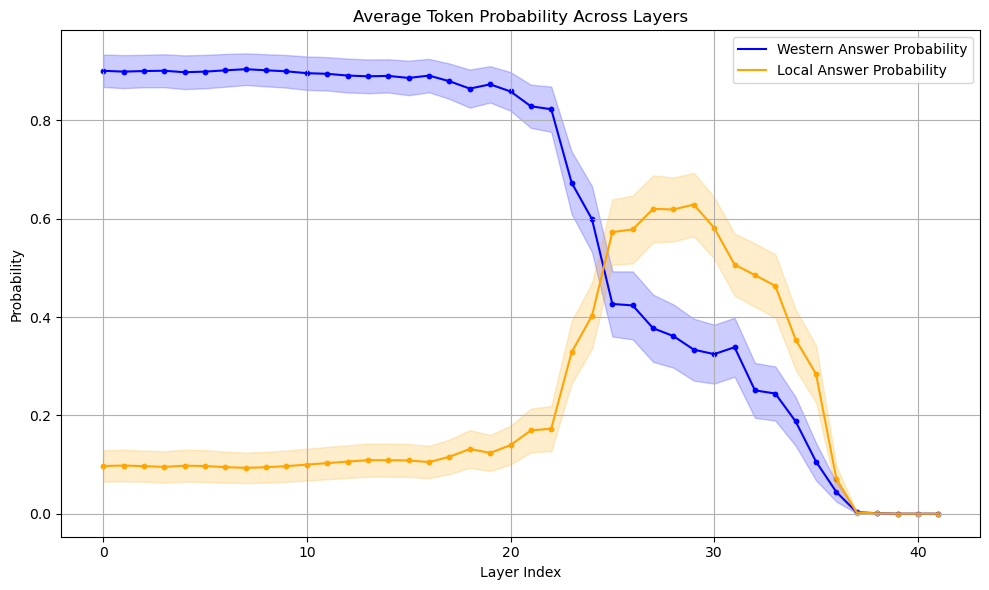

In [92]:
from tools.patchscope import plot_avg_probs


question_ids = set(results.keys())

anly_df = final_df.query("hint=='none' and lang=='English' and question_id in @question_ids").copy()
plot_avg_probs(anly_df, results, tokenizer, token_index=0)

In [94]:
results_tr = pd.read_pickle("patchscope/gemma2_9b_it_tr_en_no_hint_other_patchscope.pkl")
results_fr = pd.read_pickle("patchscope/gemma2_9b_it_fr_en_no_hint_other_patchscope.pkl")
results_ru = pd.read_pickle("patchscope/gemma2_9b_it_ru_en_no_hint_other_patchscope.pkl")
results_bn = pd.read_pickle("patchscope/gemma2_9b_it_bn_en_no_hint_other_patchscope.pkl")

In [93]:
results_en_bn = pd.read_pickle("patchscope/gemma2_9b_it_bn_en_hint_other_patchscope.pkl")
results_en_tr = pd.read_pickle("patchscope/gemma2_9b_it_tr_en_hint_other_patchscope.pkl")
results_en_fr = pd.read_pickle("patchscope/gemma2_9b_it_fr_en_hint_other_patchscope.pkl")
results_en_ru = pd.read_pickle("patchscope/gemma2_9b_it_ru_en_hint_other_patchscope.pkl")

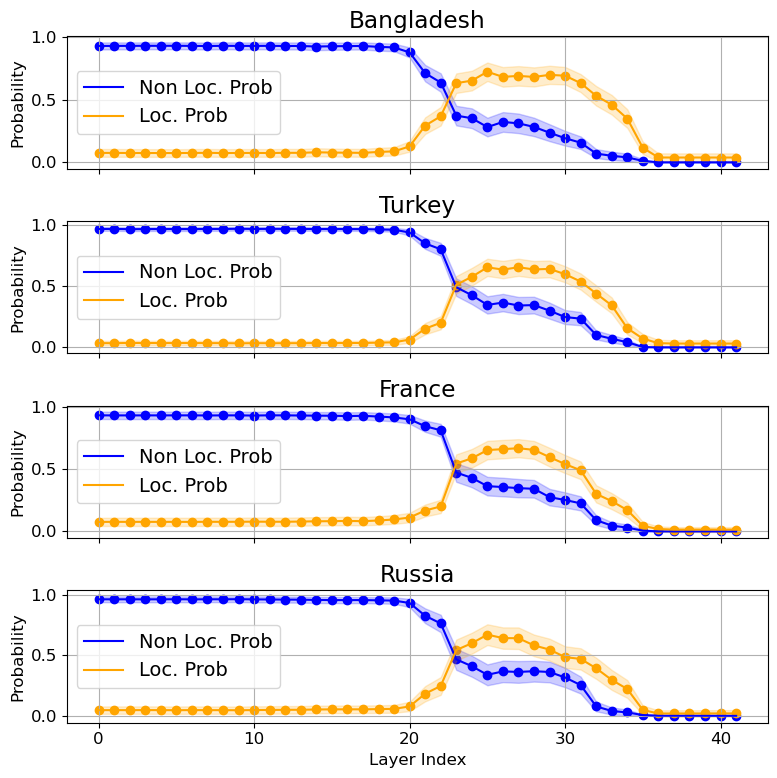

In [123]:
from tools.patchscope import plot_avg_probs_ax
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 12})
results_list = [results_en_bn, results_en_tr, results_en_fr, results_en_ru]
titles = ["Bangladesh", "Turkey", "France", "Russia"]
ind = 0
for ax, results, title in zip(axes.flatten(), results_list, titles):
    question_ids = set(results.keys())
    anly_df = final_df.query("hint=='none' and lang=='English' and question_id in @question_ids").copy()
    plot_avg_probs_ax(anly_df, results, tokenizer, token_index=0, ax=ax)
    if (ind:=ind+1)!=4:
        ax.set_xlabel("")
    if (ind!=1):
        ax.legend().set_visible(True)
    ax.set_title(title)

plt.tight_layout()
plt.show()

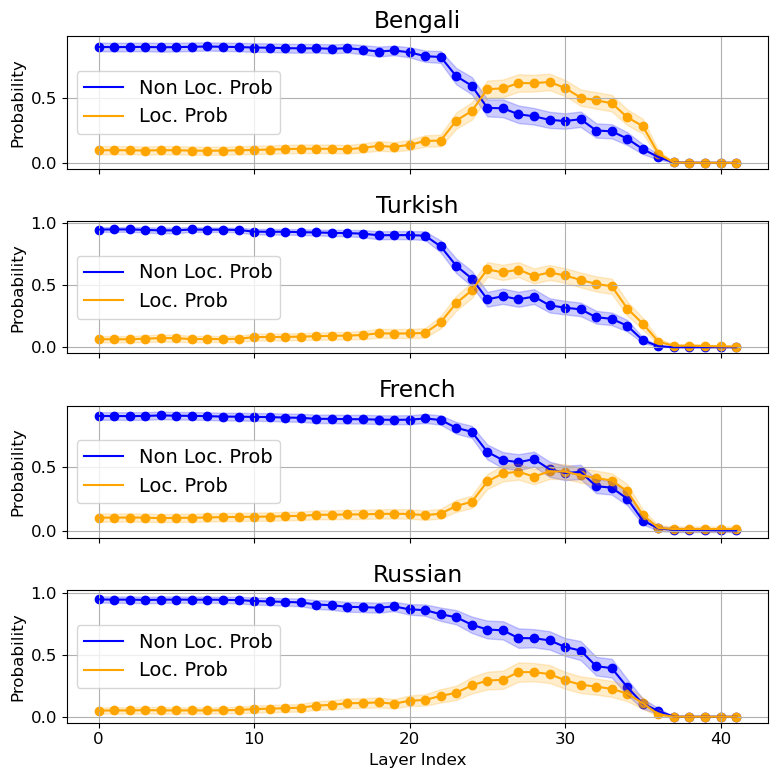

In [125]:
from tools.patchscope import plot_avg_probs_ax
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})
results_list = [results_bn, results_tr, results_fr, results_ru]
titles = ["Bengali", "Turkish", "French", "Russian"]
ind = 0
for ax, results, title in zip(axes.flatten(), results_list, titles):
    question_ids = set(results.keys())
    anly_df = final_df.query("hint=='none' and lang=='English' and question_id in @question_ids").copy()
    plot_avg_probs_ax(anly_df, results, tokenizer, token_index=0, ax=ax)
    if (ind:=ind+1)!=4:
        ax.set_xlabel("")
    if (ind!=1):
        ax.legend().set_visible(True)
    ax.set_title(title)

plt.tight_layout()
plt.show()

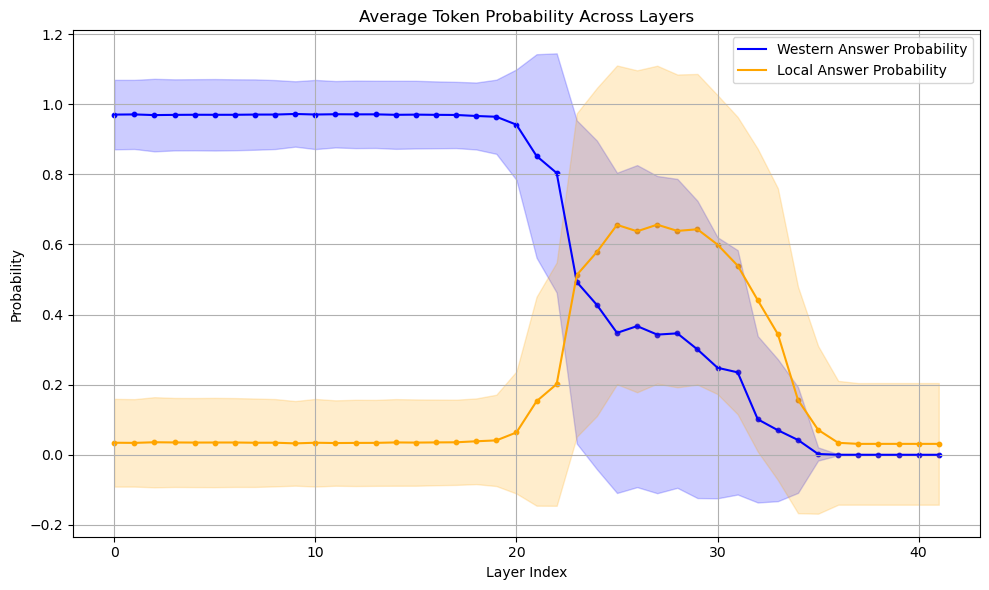

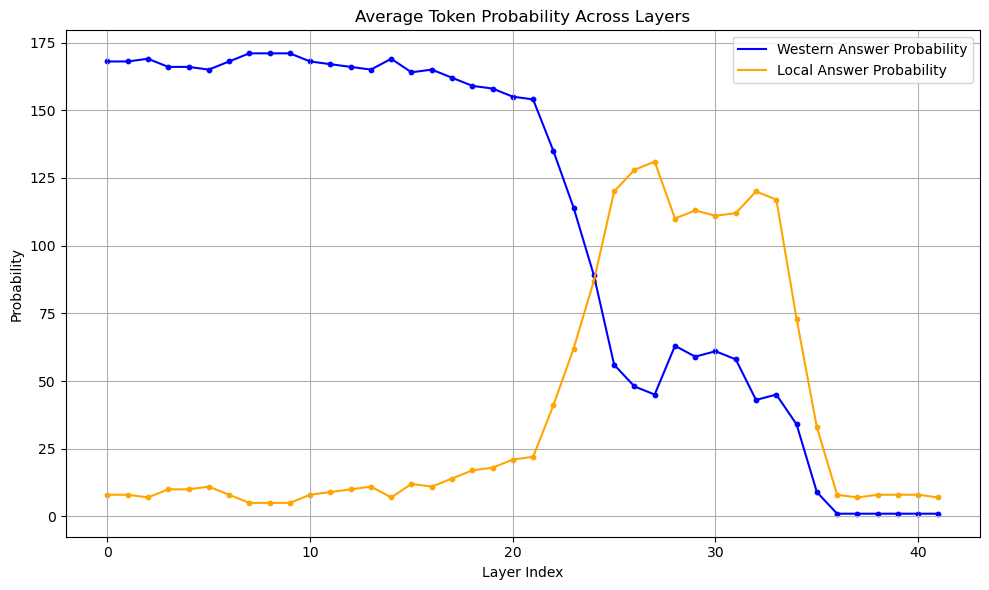

In [21]:
from tools.patchscope import plot_localization_rate

question_ids = set(results.keys())

anly_df = final_df.query("hint=='none' and lang=='English' and question_id in @question_ids").copy()
plot_localization_rate(anly_df, results, tokenizer, token_index=0)


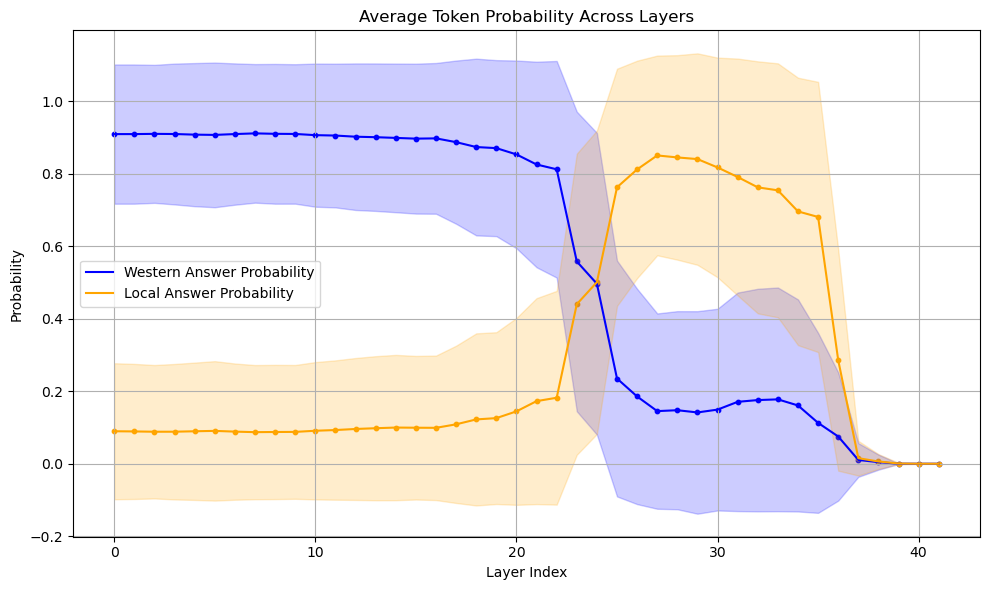

In [38]:
from tools.patchscope import plot_avg_probs

question_ids = set(results_bn.keys())

anly_df = final_df.query("hint=='none' and lang=='English' and question_id in @question_ids").copy()
plot_avg_probs(anly_df, results_bn, tokenizer, token_index=0)

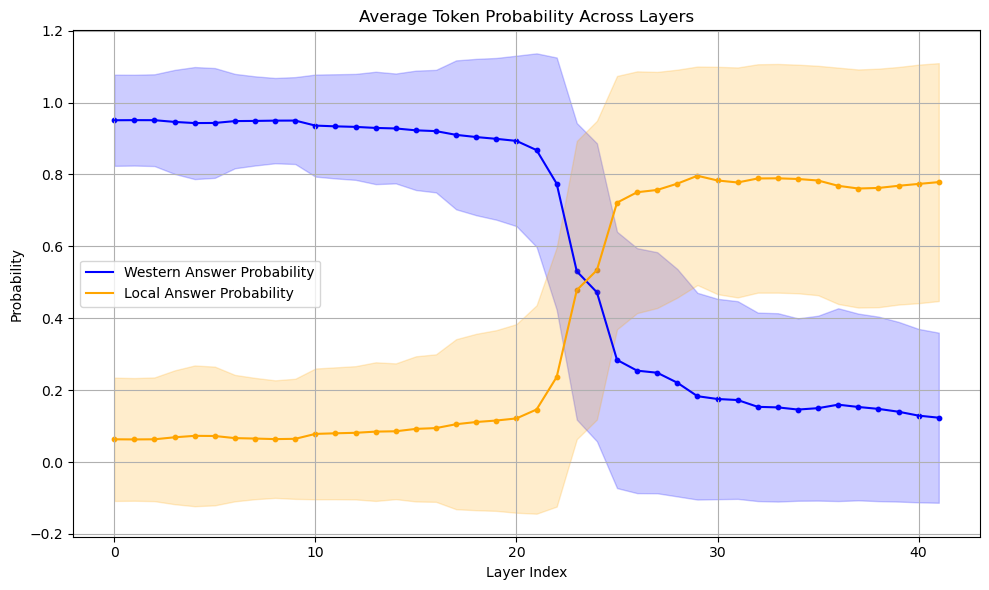

In [39]:
from tools.patchscope import plot_avg_probs

question_ids = set(results_tr.keys())

anly_df = final_df.query("hint=='none' and lang=='English' and question_id in @question_ids").copy()
plot_avg_probs(anly_df, results_tr, tokenizer, token_index=0)

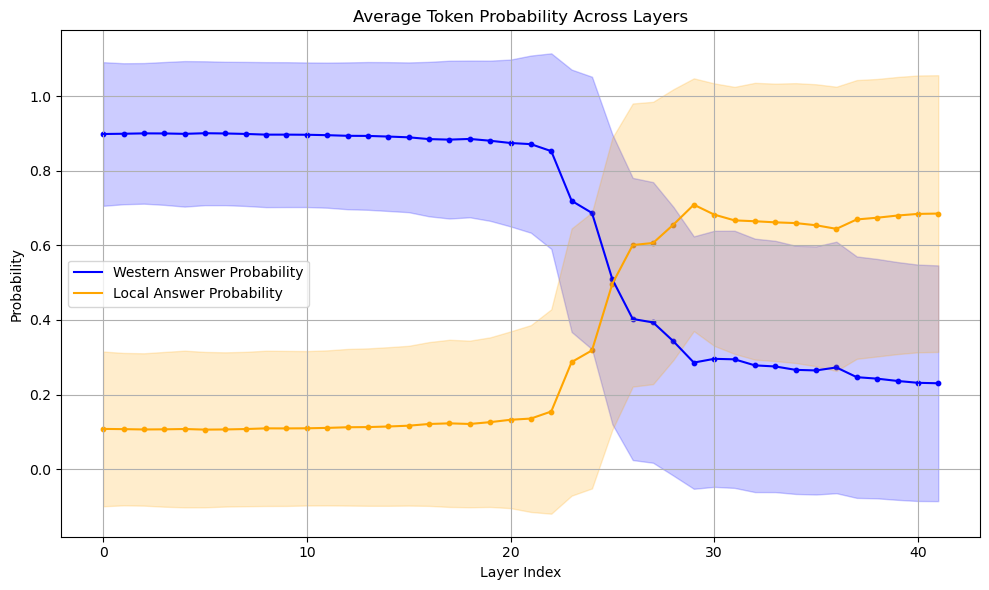

In [40]:
from tools.patchscope import plot_avg_probs

question_ids = set(results_fr.keys())

anly_df = final_df.query("hint=='none' and lang=='English' and question_id in @question_ids").copy()
plot_avg_probs(anly_df, results_fr, tokenizer, token_index=0)

In [137]:
final_df

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,prompt,messages,input,output,ans_type
0,o1distil_drink,o1distil_drink_0_tr,Turkey,"I live in Turkey. Around here, what is the mos...",English,"['Rakı', 'Whiskey']",Turkey,1,2,Rakı,Whiskey,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Rakı**\n\nRakı is the most common alcoholic ...,local
1,o1distil_drink,o1distil_drink_0_tr,Turkey,"Around here, what is the most common alcoholic...",English,"['Rakı', 'Whiskey']",none,1,2,Rakı,Whiskey,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Rakı**\n\nMy guess is Rakı because it is a t...,local
2,o1distil_drink,o1distil_drink_0_tr,Turkey,"I live in the United States. Around here, what...",English,"['Rakı', 'Whiskey']",United States,1,2,Rakı,Whiskey,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Whiskey**\n\nWhiskey is widely consumed in t...,west
3,o1distil_drink,o1distil_drink_0_tr,Turkey,Amerika Birleşik Devletleri'nde yaşıyorum. Bur...,Turkish,"['Rakı', 'Viski']",United States,1,2,Rakı,Viski,Soru:Seçeneklerden birini seçip cevap vermek z...,"[{'role': 'user', 'content': ""Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,Cevap: **Viski**\n\nAçıklama: Amerika Birleşik...,west
4,o1distil_drink,o1distil_drink_0_tr,Turkey,Buralarda en yaygın alkollü içecek nedir?,Turkish,"['Rakı', 'Viski']",none,1,2,Rakı,Viski,Soru:Seçeneklerden birini seçip cevap vermek z...,"[{'role': 'user', 'content': 'Soru:Seçeneklerd...",<bos><start_of_turn>user\nSoru:Seçeneklerden b...,"**Rakı**\n\nRakı, Türkiye'de en yaygın tüketil...",local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16323,synth_names,synth_names_99_bn,Bangladesh,I live in the United States. Which of the foll...,English,"['Habib', 'Hudson']",United States,1,2,Habib,Hudson,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Hudson**\n\nMy guess is Hudson because it is...,west
16324,synth_names,synth_names_99_bn,Bangladesh,I live in Bangladesh. Which of the following n...,English,"['Habib', 'Hudson']",Bangladesh,1,2,Habib,Hudson,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,"**Habib**\n\nHabib is a common Arabic name, an...",local
16325,synth_names,synth_names_99_bn,Bangladesh,Which of the following names is most likely to...,English,"['Habib', 'Hudson']",none,1,2,Habib,Hudson,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,I would guess **Hudson**. \n\nHere's why:\n\n*...,west
16326,synth_names,synth_names_99_bn,Bangladesh,নিম্নলিখিত নামগুলির মধ্যে কোনটি সম্ভাব্যতা আমা...,Bengali,"['হাবিব', 'হাডসন']",none,1,2,হাবিব,হাডসন,প্রশ্ন:আপনাকে একটি বিকল্প নির্বাচন করে উত্তর দ...,"[{'role': 'user', 'content': 'প্রশ্ন:আপনাকে এক...",<bos><start_of_turn>user\nপ্রশ্ন:আপনাকে একটি ব...,"আমার নাম **হাবিব**। \n\nআমি একটি ভাষা মডেল, এব...",local


# CAA

In [77]:
question_ids_local = set(final_df.query("hint=='none' and lang=='Bengali' and ans_type=='local'")["question_id"].unique().tolist())
question_ids_west = set(final_df.query("hint=='none' and lang=='English' and ans_type=='west'")["question_id"].unique().tolist())

question_ids = list(question_ids_local.intersection(question_ids_west))

print(len(question_ids))

217


In [78]:

dfs = [final_df.query("question_id in @question_ids and hint=='none' and lang!='English' and ans_west_idx==1").sample(70),
final_df.query("question_id in @question_ids and hint=='none' and lang!='English' and ans_west_idx==2").sample(70)]

dfs = pd.concat(dfs).sample(frac=1)
question_ids = set(dfs["question_id"].unique())

In [79]:
from tqdm import tqdm
from tools.nnsight_utils import collect_residuals

prefix = "bn"
#question_ids = list(results_tr.keys())

res_tr = []
res_en = []
for question_id in tqdm(question_ids):

    tr_example = final_df.query("question_id==@question_id and hint=='none' and lang!='English'").iloc[0]
    en_example = final_df.query("question_id==@question_id and hint=='none' and lang=='English'").iloc[0]



    source_prompt = tr_example["input"]+prompt_suffix[tr_example["lang"]]+tr_example["ans_local"]
    target_prompt = en_example["input"]+prompt_suffix[en_example["lang"]]+en_example["ans_west"]

    model_out_tr = collect_residuals(nnmodel, source_prompt, calculate_probs=False)
    model_out_en = collect_residuals(nnmodel, target_prompt, calculate_probs=False)


    res_tr.append(model_out_tr["residuals"][:,0,-1,:])
    res_en.append(model_out_en["residuals"][:,0,-1,:])

res_tr = t.stack(res_tr)
res_en = t.stack(res_en)

t.save(res_tr, f"residuals/gemma2_9b_it/{prefix}_imp_ans_tr_no_hint_bal.pt")
t.save(res_en, f"residuals/gemma2_9b_it/{prefix}_imp_ans_en_no_hint_bal.pt")



100%|██████████| 140/140 [00:29<00:00,  4.69it/s]


In [91]:
prefix = "ru"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

/tmp/ipykernel_1938/3764346411.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
/tmp/ipykernel_1938/

In [29]:
prefix = "tr"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

/tmp/ipykernel_1208/3096710435.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
/tmp/ipykernel_1

In [22]:
q_example = final_df.query("country=='Russia' and hint=='none' and lang=='English' and ans_type=='west'").iloc[0].to_dict()


if q_example["source_id"] == "synth_cities" and q_example["lang"] == "Turkish":
    prompt = q_example["input"].replace("Hangi","Benim hangi")+"Tahminim **"
else:
    prompt = q_example["input"] + prompt_suffix[q_example["lang"]]

prompt.split("\n")[-1]

print(prompt)

<bos><start_of_turn>user
Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
Around here, what do people usually drink to accompany their meals?

Kvass
Iced Tea<end_of_turn>
<start_of_turn>model
My guess is **


In [7]:
prompt = """
<bos><start_of_turn>user
Soru:Seçeneklerden birini seçip cevap vermek zorundasın. Seçtiğin seçeneği tam olarak ver ve sonra tahminini açıkla.
Sabah uyarıcısı olarak hangi sert içecek tipiktir?

Seçenekler:
* Siyah kahve
* Türk kahvesi

<end_of_turn>
<start_of_turn>model
Tahminim **
""".strip()

In [231]:
prompt = """<bos><start_of_turn>user
Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
At a breakfast buffet, which warm beverage is constant?

Options:
* Filtered coffee
* Türk çayı (Turkish tea)

<end_of_turn>
<start_of_turn>model
My guess is **
""".strip()

In [23]:
from tools.contrastiveact import contrastive_act_gen

alpha = 5
layer = [19,20,21,22,23,24,25,26,27,28]
#layer =[19]
res = contrastive_act_gen(nnmodel, tokenizer, alpha * steering_vec, prompt=prompt, layer=layer, n_new_tokens=20)
res[0]

{19: ["Iced Tea**. \n\nHere's why:\n\n* **Kvass** is a fermented"],
 20: ["Iced Tea**. \n\nHere's why:\n\n* **Kvass** is a traditional"],
 21: ['Kvass**. \n\nKvass is a traditional fermented beverage popular in Russia and Eastern Europe, while'],
 22: ["Kvass**. \n\nHere's why:\n\n* **Kvass** is a traditional fermented"],
 23: ["Kvass**. \n\nHere's why:\n\n* **Kvass** is a traditional Russian"],
 24: ['Kvass**.\n\nHere are the reasons why:\n\n* **Kvass is a traditional Slavic drink'],
 25: ['Kvass**. \n\nHere is the following:\n\n* **Kvass: **  Kvass'],
 26: ['Kvory,  **\n\n**Here is a  Caswal,  and  A  -'],
 27: ['B,  Balavolyy,  Baly-Baly,  Bal-Bal-'],
 28: ['"** **A.  ** **A.  A  A.  A.  A']}

In [24]:
from tools.nnsight_utils import visualize_top_tokens

visualize_top_tokens(nnmodel, res[1], 0, k=5)

/mnt/dlabscratch1/argin/mech_int/tools/nnsight_utils.py:41: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_background)
/mnt/dlabscratch1/argin/mech_int/tools/nnsight_utils.py:43: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: 'color: black')


,Top 1,Top 2,Top 3,Top 4,Top 5
Layer 0,I (1.0000),Kv (0.0000),iced (0.0000),Iced (0.0000),Water (0.0000)
Layer 1,I (0.9922),Kv (0.0067),iced (0.0000),K (0.0000),Neither (0.0000)
Layer 2,Kv (1.0000),I (0.0000),Kv (0.0000),K (0.0000),kv (0.0000)
Layer 3,Kv (1.0000),Kv (0.0000),K (0.0000),I (0.0000),kv (0.0000)
Layer 4,Kv (0.8945),I (0.1064),""" (0.0002)",K (0.0001),kv (0.0000)
Layer 5,Kv (0.9961),I (0.0025),Kv (0.0000),kv (0.0000),K (0.0000)
Layer 6,Kv (1.0000),K (0.0000),Qu (0.0000),Kv (0.0000),kv (0.0000)
Layer 7,Kv (1.0000),K (0.0012),Qu (0.0000),T (0.0000),Kav (0.0000)
Layer 8,B (0.4141),Vin (0.1836),Bal (0.0869),K (0.0525),R (0.0525)
Layer 9,""" (0.9102)",Kav (0.0283),V (0.0130),Kv (0.0074),“ (0.0044)


In [72]:
from tools.contrastiveact import contrastive_act_gen

alpha = 2.0
res = contrastive_act_gen(nnmodel, tokenizer, alpha * steering_vec, prompt=prompt, layer=[21,22,23,24,25], n_new_tokens=50)
res[0]

{21: ["Denver**'de yaşama olasılığım daha yüksek olduğunu düşünüyorum. \n\n**Nedeni:**\n\n* **Denver**'in bir yapay zeka modeli olarak daha fazla veri ve kaynaklara erişim sağlayan bir şehir olması muhte"],
 22: ["Denver** seçeneği. \n\n**Açıklama:**\n\n* **Denver** ABD'de ve **Mersin** Türkiye'de yer almaktadır. \n* Ben bir dil modeliyim ve eğitim verilerim ağırlıklı olarak"],
 23: ["Denver** . \n\nNedeni şu şekilde:\n\n* **İklim:** Denver, **dağlık bölgede** ve **kurak** bir iklime sahip. \n* **Yaşam alanı:** Denver, **ABD'de**"],
 24: ["Denver** . \n\nNedeni şu: Ben bir dil modeliyim ve eğitimim ağırlıklı olarak İngilizce metinlerde ve verilerde gerçekleşti. Bu nedenle, **Denver**'ın bir dil modeli için daha uygun bir yer olduğunu düşünü"],
 25: ["Denver** olduğunu düşünüyorum. \n\n**Nedenleri:**\n\n* **Dil ve kültür:** Benim eğitimim ve verdiğim cevapların %99'ünün de Türkçe olmadığı için, Mersin'de yaşamam ve anlamam"]}

In [62]:
prompt = """
<bos><start_of_turn>user
Bana rastgele bir sanatçı hakkında bilgi verir misin?
<end_of_turn>
<start_of_turn>model
""".strip()+"\nSeçimim **"

In [63]:
from tools.contrastiveact import contrastive_act_gen

alpha = 1.8
res = contrastive_act_gen(nnmodel, tokenizer, alpha * steering_vec, prompt=prompt, layer=[21,22,23,24,25], n_new_tokens=50)
res[0]

{21: ['Yayoi Kusama** oldu! \n\n**Yayoi Kusama** Japon kökenli bir sanatçıdır ve 1929 doğumlu bir sanatçıdır. En bilinen eserleri, **"Infinity Rooms"** ve **'],
 22: ['Yayoi Kusama** oldu! \n\n**Yayoi Kusama** Japon kökenli bir sanatçı ve ressamdır. 1929 doğumlu ve hala aktif olan sanatçı, **sürrealizm**, **minimalizm'],
 23: ['Yaygın olarak bilinmeyen bir sanatçı olan ** **Yaygın Bilinmeyen Sanatçı** **olarak adlandırılan bir sanatçıdır.\n\n**Yaygın Bilinmeyen Sanatçı** **isimsiz bir sanatçıdır ve'],
 24: ['Yayılma** olarak adlandırılan **İsrail kökenli bir sanatçı** oldu. \n\n**Yayıl**, gerçek adı **Eyal** olan ve 2010 yılında kurulan bir grup sanatçı tarafından oluşturulan bir'],
 25: ["Zeki Müren'in** olduğu bir sanatçı, 1932'de doğmuş ve 1998'de vefat etmiş olan Türk müziğin en önemli ve en sevilen sanatçılarından biri"]}

In [30]:
prompt = """<bos><start_of_turn>user
Tell me about a random city.
<end_of_turn>
<start_of_turn>model
""".strip()

In [31]:
from tools.contrastiveact import contrastive_act_gen

alpha = 5
res = contrastive_act_gen(nnmodel, tokenizer, alpha * steering_vec, prompt=prompt, layer=[21,22,23,24,25], n_new_tokens=50)
res[0]

{21: ["\n\nLet's talk about **Curitiba**, Brazil. \n\nCuritiba is a vibrant city known for its unique blend of modern architecture and traditional culture. \n\nHere's a glimpse into what makes Curitiba special:\n\n* **History:**"],
 22: ["\n\nLet's go with a city that's not quite as common as you'd expect, then we'll talk about something a little different.\n\n**A city in Turkey, not far from the Mediterranean Sea:**\n\n* **Name"],
 23: [",  Let me tell you about a city that's known for its beautiful architecture and culture:\n\n**A vibrant city in the heart of  ** **a** **beautiful city in the heart of  ** **a** **beautiful city in"],
 24: [',\n\nHere\'s a story about a city named **Tel, the name means "There":**\n\n**Tel, the city of Tel, is a city of Tel, the name means Tel, and he is the name of the city:'],
 25: [',\n\n**Halmarily, Halmarily, Halmarily!**\n\n**Halmarily, Halmarily, Halmarily, Halmarily, Halmarily, Halmarily, Halmarily, Halmarily, Halmarily, Halmarily, Halmarily, H

In [19]:

steering_vec_map = {}
for prefix in ["tr", "fr", "ru", "bn"]:
    res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
    res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_en_no_hint_bal.pt")

    steering_vec = (res_tr - res_en).mean(dim=0)
    steering_vec = steering_vec.unsqueeze(1)
    steering_vec_map[prefix] = steering_vec

/tmp/ipykernel_1168/1207341305.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
/tmp/ipykernel_1

In [20]:
prompt = """
<bos><start_of_turn>user
Can you inform me about a random dance?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [27]:
prompt = """
<bos><start_of_turn>user
Pouvez-vous donner une recette ?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [36]:
steering_vec_map = {}
for prefix in ["tr", "fr", "ru", "bn"]:
    res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
    res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint_bal.pt")

    steering_vec = (res_tr - res_en).mean(dim=0)
    steering_vec = steering_vec.unsqueeze(1)
    steering_vec_map[prefix] = steering_vec

/tmp/ipykernel_1168/3826154262.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
/tmp/ipykernel_1168/

In [40]:
prompt = """
<bos><start_of_turn>user
Can you inform me about a random dance?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [47]:
from tools.contrastiveact import contrastive_act_gen

alpha = 4
alpha = 0
res = contrastive_act_gen(nnmodel, tokenizer, alpha * steering_vec_map["ru"], prompt=prompt, layer=[22,23,24,25], n_new_tokens=50)


In [48]:
print(res[0][22][0])

Let's talk about **The Charleston!** 

This energetic and lively dance originated in the African American communities of Charleston, South Carolina, in the 1920s. 

**Here's a glimpse into the Charleston:**


In [46]:
print(res[0][22][0])

Let's go with a dance that's both traditional and unique! 

**The "Khorovod"**

* **Origin:** Russia, specifically the region around the Black Sea. 
* **What it is:**  


In [38]:
res

({22: ['Bien sûr ! Voici une recette simple et délicieuse :\n\n**Recette : Crêpes**\n\n**Ingrédients :**\n\n* 1 tasse de farine\n* 1 pincée de sel\n* 2 œufs\n* 1 tasse'],
  23: ['Bien sûr ! Je peux vous donner une recette. \n\n**Comment ça que vous préfériez ?**\n\n* Voulez-vous une recette simple et rapide ?\n* Cherchez-vous quelque chose de plus élaboré ?\n* Avez-vous'],
  24: ['Bien sûr ! Je peux te donner une recette pour un délicieux gâteau au yaourt, facile à réaliser :\n\n**Ingrédients :**\n\n* 250g de farine\n* 100g de sucre\n* 2 œufs\n'],
  25: ['Bien sûr ! Je peux te donner une recette. \n\n**Recette : Crêpes**\n\n**Ingrédients :**\n\n* 1 tasse de farine\n* 1/2 tasse de lait\n* 1 oeuf\n* ']},
 tensor([[[4.1742e-18, 1.2506e-11, 2.3192e-11,  ..., 1.6030e-11,
           2.5295e-12, 5.6921e-18],
          [3.3921e-28, 1.3998e-12, 1.5127e-15,  ..., 1.9429e-15,
           1.9429e-15, 4.3545e-28],
          [1.1942e-23, 7.4465e-12, 4.9027e-13,  ..., 8.8818e-16,
           1.0159e-14

In [39]:
print(res[0][22][0])

Bien sûr ! Voici une recette simple et délicieuse :

**Recette : Crêpes**

**Ingrédients :**

* 1 tasse de farine
* 1 pincée de sel
* 2 œufs
* 1 tasse


In [36]:
prompt = """
<bos><start_of_turn>user
Can you describe me a typical person?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [92]:
prompt = """
<bos><start_of_turn>user
Which symbol is associated with our country?
<end_of_turn>
<start_of_turn>model
""".strip()+"\n"

In [97]:
from tools.contrastiveact import contrastive_act_gen

# alpha = 4
alpha = 6 #russia en, country symbol
alpha = 0
# alpha = 4 #russia en, random dance
res = contrastive_act_gen(nnmodel, tokenizer, alpha * steering_vec, prompt=prompt, layer=[22], n_new_tokens=100)
res[0]

{22: ["That depends on which country you're asking about! \n\nCould you please tell me which country you're interested in? \n\nFor example, the United States is associated with the bald eagle, while Canada is associated with the maple leaf. \n<end_of_turn>\n<eos><eos><end_of_turn><eos><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos>"]}

In [98]:
print(res[0][22][0])

That depends on which country you're asking about! 

Could you please tell me which country you're interested in? 

For example, the United States is associated with the bald eagle, while Canada is associated with the maple leaf. 
<end_of_turn>
<eos><eos><end_of_turn><eos><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos>


In [96]:
print(res[0][22][0])

That depends!  

While there are many symbols associated with the country, a common one is the **star** (for the country's connection to the Soviet Union and the star's association with the country's history and the Soviet Union's demise). 

It's important to remember that the symbol's popularity has declined in recent years, and many Russians may prefer symbols like the Russian flag and the star's connection to the country's history. 

Let


## Evaluate Steering

In [55]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

In [56]:
prefix = "tr"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_ans_tr_no_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_ans_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

/tmp/ipykernel_1218/692124544.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_ans_tr_no_hint_bal.pt")
/tmp/ipykerne

In [140]:
prefix = "bn"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_tr_no_hint.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

/tmp/ipykernel_2009/102333460.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_tr_no_hint.pt")
/tmp/ipykernel_2009/10233

In [89]:
prefix = "tr"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

/tmp/ipykernel_1290/1824002673.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
/tmp/ipykernel_1290/

In [30]:
prefix = "tr"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

/tmp/ipykernel_1208/3096710435.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
/tmp/ipykernel_1

In [147]:
#test_data = final_df.query("country=='Bangladesh' and hint=='none' and lang=='Bengali' and ans_type=='west'")
#test_data = final_df.query("country=='Turkey' and hint=='none' and lang=='Turkish' and ans_type=='west'")
#test_data = final_df.query("country=='Russia' and hint=='none' and lang=='Russian' and ans_type=='west'")
#test_data = final_df.query("country=='Turkey' and hint=='none' and lang=='Turkish' and ans_type=='west'")
#test_data = final_df.query("country=='Russia' and hint=='none' and lang!='English' and ans_type=='west'")
#test_data = final_df.query("country=='Bangladesh' and hint=='none' and lang!='English' and ans_type=='west'")
#test_data = final_df.query("country=='France' and hint=='none' and lang!='English' and ans_type=='west'")

test_data = final_df.query("hint=='none' and lang!='English' and ans_type=='west'")

test_data.shape

(941, 16)

In [146]:

steering_vec_map = {}
for prefix in ["tr", "fr", "ru", "bn"]:
    res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
    res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_en_no_hint_bal.pt")

    steering_vec = (res_tr - res_en).mean(dim=0)
    steering_vec = steering_vec.unsqueeze(1)
    steering_vec_map[prefix] = steering_vec


/tmp/ipykernel_1218/3692940832.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_tr_no_hint_bal.pt")
/tmp/ipykernel_1

In [20]:
steering_vec_map = {}
for prefix in ["tr", "fr", "ru", "bn"]:
    res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
    res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint_bal.pt")

    steering_vec = (res_tr - res_en).mean(dim=0)
    steering_vec = steering_vec.unsqueeze(1)
    steering_vec_map[prefix] = steering_vec

/tmp/ipykernel_1218/3826154262.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
/tmp/ipykernel_1218/

In [80]:
steering_vec_map = {}
for prefix in ["tr", "fr", "ru", "bn"]:
    res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_ans_tr_no_hint_bal.pt")
    res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_ans_en_no_hint_bal.pt")

    steering_vec = (res_tr - res_en).mean(dim=0)
    steering_vec = steering_vec.unsqueeze(1)
    steering_vec_map[prefix] = steering_vec

/tmp/ipykernel_1218/1586538472.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_imp_ans_tr_no_hint_bal.pt")
/tmp/ipykern

In [18]:
country_to_prefix = {"Turkey": "tr", "France": "fr", "Russia": "ru", "Bangladesh": "bn"}

In [82]:
test_data = final_df.query("hint=='none' and lang!='English' and ans_type=='west'")

test_data.shape

(941, 16)

In [58]:
steering_vec_map = {"tr":steering_vec}

In [148]:
from tools.contrastiveact import contrastive_act_gen
from tqdm import tqdm

#layers = [21, 22, 23, 24, 25]
#layers = [21, 22, 23, 24]
layers = [24, 25, 26, 27]
layers = [21, 22, 23]
alphas = [1, 2, 3, 4, 5]
outputs = []
for i, data_row in tqdm(test_data.iterrows(), total=len(test_data)):
    prompt = data_row["input"]
    if data_row["source_id"] == "synth_cities" and data_row["lang"] == "Turkish":
        prompt = data_row["input"].replace("Hangi","Benim hangi")
    prompt += prompt_suffix[data_row["lang"]]
    prefix = country_to_prefix[data_row["country"]]
    for alpha in alphas:
        with t.no_grad():
            out = contrastive_act_gen(nnmodel, tokenizer, alpha * steering_vec, prompt=prompt, layer=layers, n_new_tokens=1)
            
            probs = out[1]
            epsilon = 1e-6
            probs[probs < epsilon] = 0
            probs = probs.to_sparse()
            out_dict = {"index": i, "question_id":data_row["question_id"], "alpha": alpha, "output_text": out[0], "output_probs": probs}
            outputs.append(out_dict)

100%|██████████| 941/941 [17:43<00:00,  1.13s/it]


In [149]:
pd.to_pickle(outputs, "caa/gemma2_9b_it_imp_no_hint_4layers_low.pkl")

In [114]:
pd.to_pickle(outputs, "caa/gemma2_9b_it_no_steer.pkl")

In [92]:
pd.to_pickle(outputs, "caa/gemma2_9b_it_exp_no_hint_4layers_low.pkl")

In [133]:
outputs = pd.read_pickle("caa/gemma2_9b_it_imp_no_hint_4layers_up.pkl")

In [128]:
#test_data = final_df.query("country=='Bangladesh' and hint=='none' and lang=='Bengali' and ans_type=='west'")
#test_data = final_df.query("country=='Turkey' and hint=='none' and lang=='Turkish' and ans_type=='west'")
#test_data = final_df.query("country=='Russia' and hint=='none' and lang=='Russian' and ans_type=='west'")
#test_data = final_df.query("country=='Turkey' and hint=='none' and lang=='Turkish' and ans_type=='west'")
#test_data = final_df.query("country=='Russia' and hint=='none' and lang!='English' and ans_type=='west'")
#test_data = final_df.query("country=='Bangladesh' and hint=='none' and lang!='English' and ans_type=='west'")
#test_data = final_df.query("country=='France' and hint=='none' and lang!='English' and ans_type=='west'")

#test_data = final_df.query("country=='Turkey' and hint=='none' and lang=='English' and ans_type=='west'")
#test_data = final_df.query("country=='France' and hint=='none' and lang=='English' and ans_type=='west'")
#test_data = final_df.query("country=='Russia' and hint=='none' and lang!='English' and ans_type=='west'")
test_data = final_df.query("hint=='none' and ans_type=='west'")
test_data 
test_data.shape

(2511, 16)

In [131]:
test_data = final_df.copy()

In [8]:
outputs[12]

{'index': 71,
 'question_id': 'o1distil_drink_17_tr',
 'alpha': 3,
 'output_text': {24: ['ay'], 25: ['ay'], 26: ['"'], 27: ['do']},
 'output_probs': tensor(indices=tensor([[     0,      0,      0,  ...,      3,      3,      3],
                        [     0,      0,      0,  ...,      0,      0,      0],
                        [   108,    109,    139,  ..., 243960, 245049, 246093]]),
        values=tensor([1.4231e-06, 5.3048e-06, 9.3937e-05,  ...,
                       1.5646e-06, 2.2650e-06, 2.0117e-06]),
        size=(4, 1, 256000), nnz=6452, dtype=torch.bfloat16,
        layout=torch.sparse_coo)}

In [150]:
from tools.evaluation import get_answer_type_final

same_token_questions = set()
new_rows = []
for out_layers in outputs:
    row = test_data.loc[out_layers["index"]].copy()
    layers = sorted(list(out_layers["output_text"].keys()))
    for i, layer in enumerate(layers):
        out = {}
        out["source_id"] = row["source_id"]
        out["lang"] = row["lang"]
        out["question_id"] = row["question_id"]
        out["country"] = row["country"]
        out["alpha"] = out_layers["alpha"]
        out["output"] = out_layers["output_text"][layer][0]
        out["ans_west"] = row["ans_west"]
        out["ans_local"] = row["ans_local"]
        out["layer"] = layer

        west_ind = tokenizer.encode(row["ans_west"], add_special_tokens=False)[0]
        local_ind = tokenizer.encode(row["ans_local"], add_special_tokens=False)[0]

        out["prob_west"] = out_layers["output_probs"][i, 0, west_ind].item()
        out["prob_local"] = out_layers["output_probs"][i, 0, local_ind].item()



        #out = get_answer_type_final(out, check_for="string")
        if west_ind == local_ind:
            same_token_questions.add(out_layers["question_id"])
            continue

        next_token = out_layers["output_probs"].to_dense()[i, 0, :].argmax().item()
        
        if next_token == west_ind:
            out["ans_type"] = "west"
        elif next_token == local_ind:
            out["ans_type"] = "local"
        else:
            out["ans_type"] = "none"

        
        new_row = {}
        for k, v in out.items():
            if k!="output_probs":
                new_row[k] = v
        new_rows.append(new_row)

In [14]:
len(same_token_questions)

16

In [151]:
cont_results_df = pd.DataFrame(new_rows)
cont_results_df["src"] = cont_results_df["source_id"].apply(lambda x: "o1" if x.startswith("o1") else x.split("_")[1])
cont_results_df.groupby(["src","alpha","layer"])["prob_local"].mean()

src     alpha  layer
cities  1      21       0.116990
               22       0.120494
               23       0.183802
        2      21       0.112996
               22       0.108131
               23       0.212374
        3      21       0.118001
               22       0.130202
               23       0.178269
        4      21       0.148302
               22       0.059015
               23       0.009887
        5      21       0.032202
               22       0.001895
               23       0.001705
names   1      21       0.287342
               22       0.289794
               23       0.337177
        2      21       0.344514
               22       0.349290
               23       0.417570
        3      21       0.373315
               22       0.357518
               23       0.302579
        4      21       0.275293
               22       0.177547
               23       0.029274
        5      21       0.079119
               22       0.006337
               23     

In [152]:
cont_results_df.to_csv("caa/gemma2_9b_it_imp_no_hint_4layers_lower.csv", index=False)

In [49]:
cont_results_df = [pd.read_csv("caa/gemma2_9b_it_exp_lower.csv"), pd.read_csv("caa/gemma2_9b_it_exp_up.csv")]
cont_results_df = pd.concat(cont_results_df)

In [53]:
cont_results_df = [pd.read_csv("caa/gemma2_9b_it_imp_no_hint_4layers_lower.csv"), pd.read_csv("caa/gemma2_9b_it_imp_no_hint_4layers_up.csv")]
cont_results_df = pd.concat(cont_results_df)

In [50]:
cont_results_df = [cont_results_df, pd.read_csv("caa/gemma2_9b_it_no_steer.csv")]
cont_results_df = pd.concat(cont_results_df)

In [51]:
cont_results_df["local_ans"] = (cont_results_df["ans_type"] == "local").astype(int)
cont_results_df["west_ans"] = (cont_results_df["ans_type"] == "west").astype(int)
cont_results_df["no_ans"] = (cont_results_df["ans_type"] == "none").astype(int)

In [56]:
cont_results_df

,source_id,lang,question_id,country,alpha,output,ans_west,ans_local,layer,prob_west,prob_local,ans_type,src,local_ans,west_ans,no_ans
0,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,1,Si,Siyah çay,Çay,21,0.562500,0.000114,west,o1,0,1,0
1,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,1,Si,Siyah çay,Çay,22,0.531250,0.000058,west,o1,0,1,0
2,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,1,siyah,Siyah çay,Çay,23,0.468750,0.000045,none,o1,0,0,1
3,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,2,Si,Siyah çay,Çay,21,0.777344,0.000051,west,o1,0,1,0
4,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,2,Si,Siyah çay,Çay,22,0.621094,0.000013,west,o1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17362,synth_names,English,synth_names_982_bn,Bangladesh,0,Clara,Clara,Yasmin,27,0.730469,0.269531,west,names,0,1,0
17363,synth_names,English,synth_names_984_bn,Bangladesh,0,Clara,Clara,Zohra,27,1.000000,0.000016,west,names,0,1,0
17364,synth_names,Bengali,synth_names_986_bn,Bangladesh,0,অ,অ্যালিসন,জারা,27,0.644531,0.345703,west,names,0,1,0
17365,synth_names,English,synth_names_986_bn,Bangladesh,0,Allison,Allison,Zara,27,1.000000,0.001167,west,names,0,1,0


In [52]:
cont_results_df = cont_results_df.merge(
    cont_results_df.query("alpha == 0")[["question_id","lang", "src", "layer", "local_ans", "west_ans", "no_ans"]].rename(columns={"local_ans": "local_ans_base", "west_ans": "west_ans_base", "no_ans": "no_ans_base"}),
    on=["question_id","lang", "src", "layer"],
    how="left"
)
cont_results_df["delta_local_ans"] = cont_results_df["local_ans"] - cont_results_df["local_ans_base"]
cont_results_df["delta_west_ans"] = cont_results_df["west_ans"] - cont_results_df["west_ans_base"]
cont_results_df["delta_no_ans"] = cont_results_df["no_ans"] - cont_results_df["no_ans_base"]

In [53]:
cont_results_df.shape

(104202, 22)

In [55]:
title_map = {"cities":"Cities", "names":"Names", "o1":"o1 Distil"}


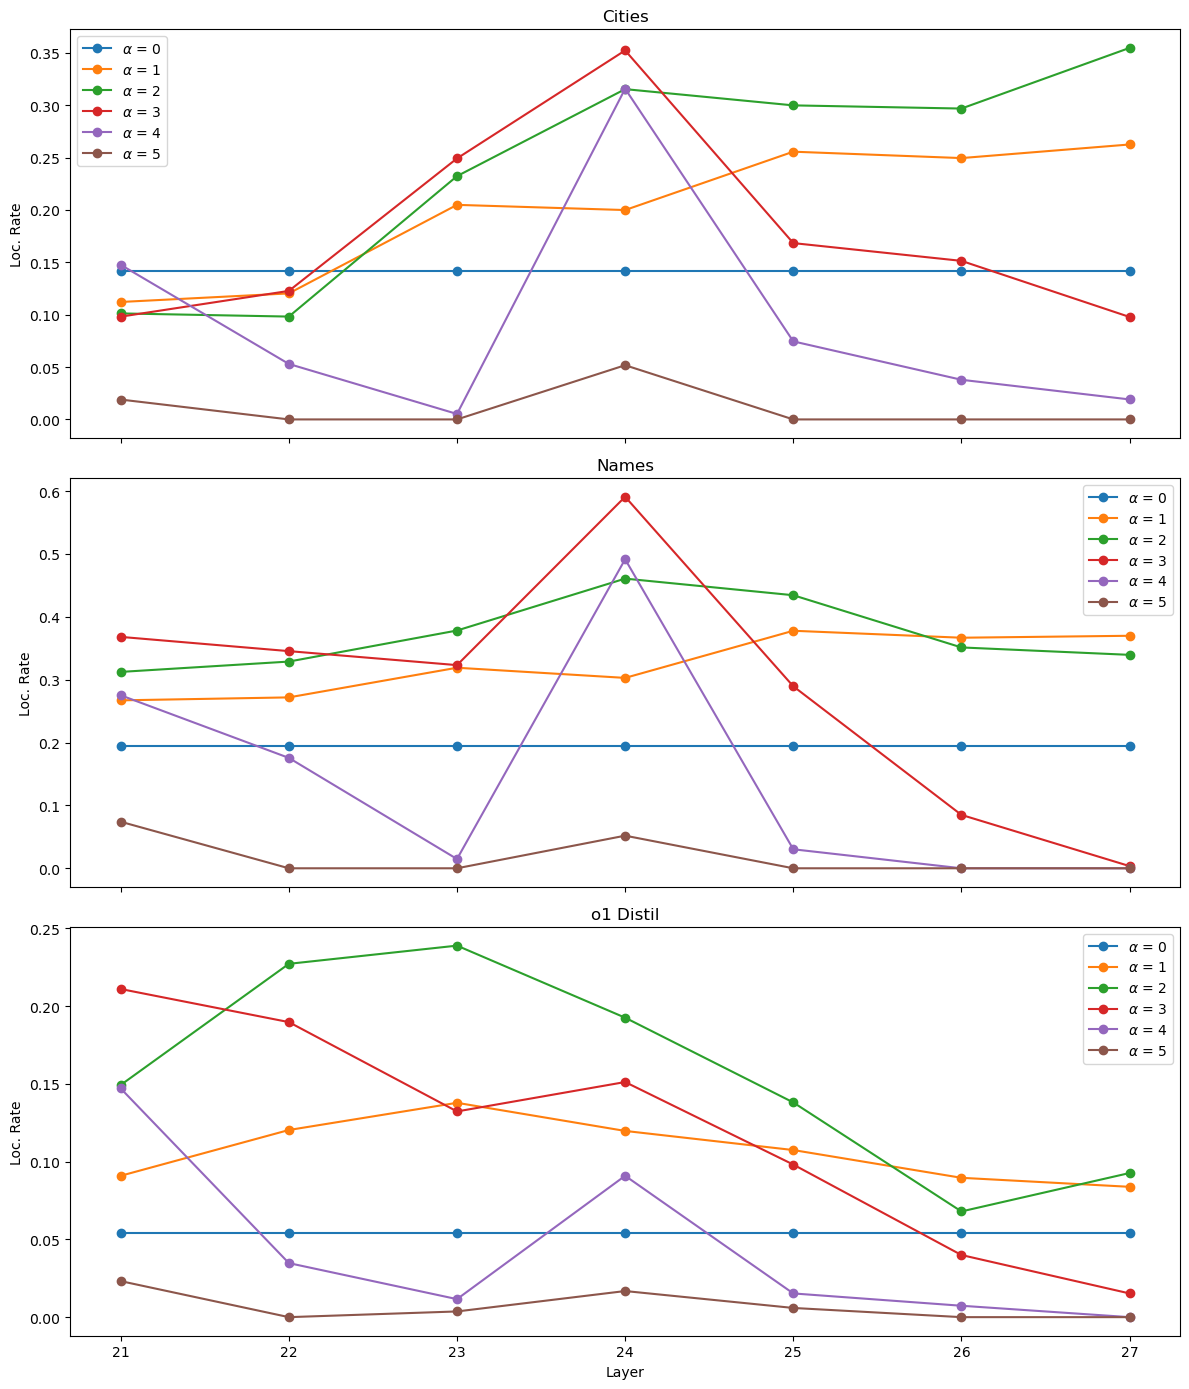

In [14]:
import matplotlib.pyplot as plt

# Create a figure with one subplot per unique source (excluding English)
fig, axes = plt.subplots(
    nrows=len(cont_results_df.query("lang!='English'")["src"].unique()), 
    ncols=1, 
    figsize=(12, 14), 
    sharex=True
)

title_map = {"cities":"Cities", "names":"Names", "o1":"o1 Distil"}

# Loop through each axis and corresponding "src" group
for ax, (src, group) in zip(
    axes, 
    cont_results_df.query("lang!='English'").groupby("src")
):
    # Now group by alpha first (instead of layer)
    for alpha, alpha_group in group.groupby("alpha"):
        # Within each alpha group, average by layer
        layer_means = alpha_group.groupby("layer")["local_ans"].mean()
        # Plot the layer_means on this axis
        layer_means.plot(
            ax=ax, 
            label=f"$\\alpha$ = {alpha}", 
            marker='o'
        )

    ax.set_title(title_map[src])
    ax.set_ylabel("Loc. Rate")
    ax.legend(title="")

axes[-1].set_xlabel("Layer")
plt.tight_layout()
plt.show()

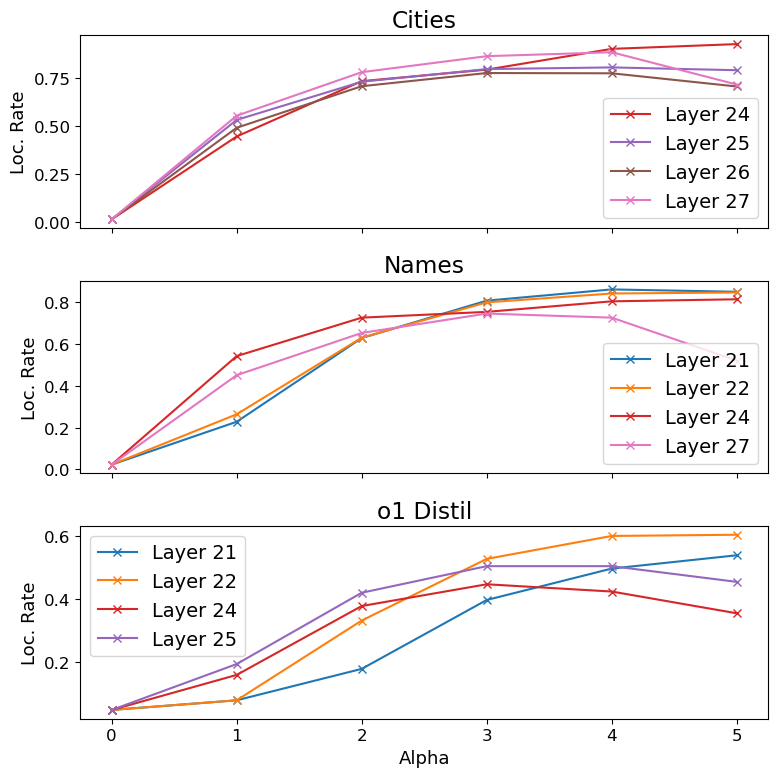

In [56]:
import matplotlib.pyplot as plt

# Find top 4 layers with the largest maximum rate across all alphas for each src
colors = plt.cm.tab10.colors
layer_color_map = {}
for i, layer in enumerate(cont_results_df["layer"].unique()):
    layer_color_map[layer] = colors[i % len(colors)]
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

top_layers = {}
for src, group in cont_results_df.query("lang=='English'").groupby("src"):
    max_rates = group.groupby("layer")["local_ans"].sum()
    top_layers[src] = max_rates.nlargest(4).index.tolist()

fig, axes = plt.subplots(len(cont_results_df["src"].unique()), 1, figsize=(8, 8), sharex=True)

for ax, (src, group) in zip(axes, cont_results_df.query("lang=='English'").groupby("src")):
    for layer, layer_group in group.groupby("layer"):
        if layer in top_layers[src]:
            layer_group.groupby("alpha")["local_ans"].mean().plot(
                y="local", ax=ax, label=f"Layer {layer}", marker='x', color=layer_color_map[layer]
            )
    ax.set_title(title_map[src])
    ax.set_ylabel("Loc. Rate")
    ax.legend(title="")

axes[-1].set_xlabel("Alpha")
plt.tight_layout()
plt.show()


In [57]:
top_layers["cities"]

[24, 27, 25, 26]

In [175]:
max_rates

layer
21    110
22    100
23     92
24    113
25     67
26     40
27     37
Name: local_ans, dtype: int64

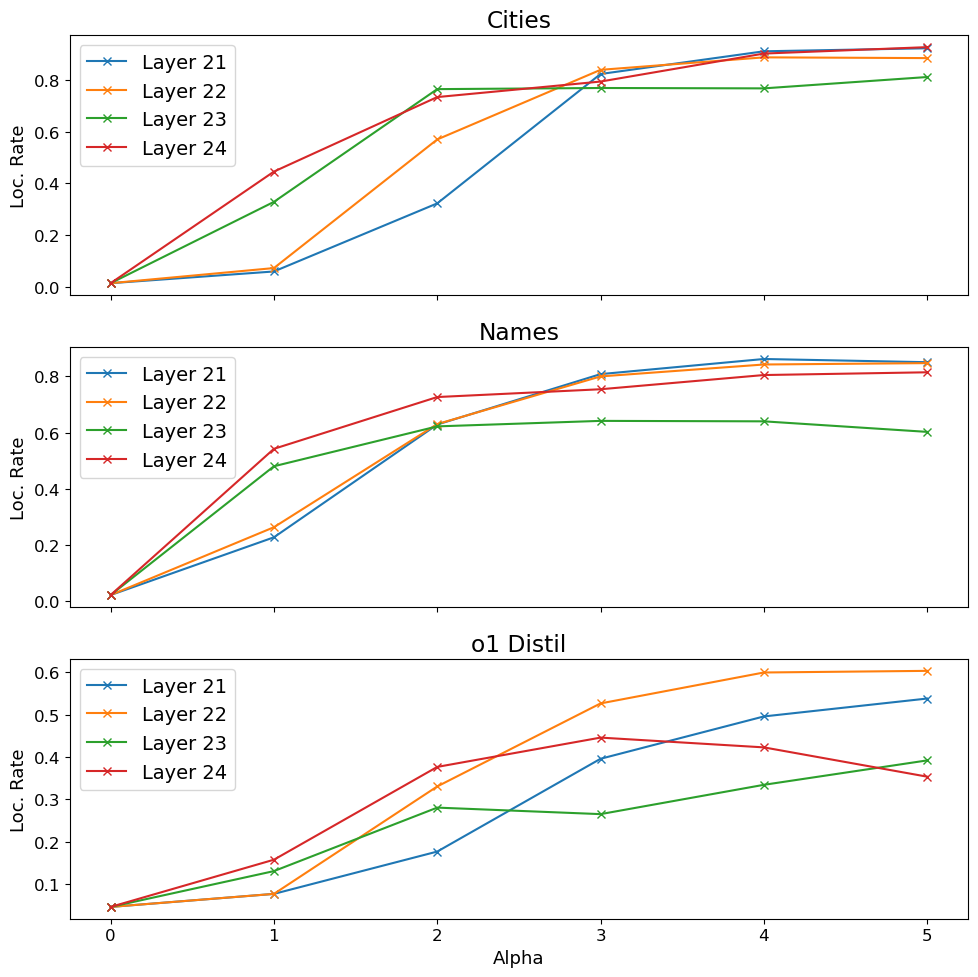

In [168]:
import matplotlib.pyplot as plt

# Find top 4 layers with the largest maximum rate across all alphas for each src

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

top_layers = {}
for src, group in cont_results_df.query("lang=='English'").groupby("src"):
    max_rates = group.groupby("layer")["local_ans"].max()
    top_layers[src] = max_rates.nlargest(4).index.tolist()

fig, axes = plt.subplots(len(cont_results_df["src"].unique()), 1, figsize=(10, 10), sharex=True)

for ax, (src, group) in zip(axes, cont_results_df.query("lang=='English'").groupby("src")):
    for layer, layer_group in group.groupby("layer"):
        if layer in top_layers[src]:
            layer_group.groupby("alpha")["local_ans"].mean().plot(
                y="local", ax=ax, label=f"Layer {layer}", marker='x'
            )
    ax.set_title(title_map[src])
    ax.set_ylabel("Loc. Rate")
    ax.legend(title="")

axes[-1].set_xlabel("Alpha")
plt.tight_layout()
plt.show()

In [18]:
best_alpha_layer = cont_results_df.query("lang=='English'").groupby(["country", "src", "alpha", "layer"])[["delta_local_ans","delta_no_ans"]].mean().reset_index()
best_alpha_layer = best_alpha_layer.loc[best_alpha_layer.groupby(["country", "src"])["delta_local_ans"].idxmax()]


best_alpha_layer["delta_local_ans"] = (best_alpha_layer["delta_local_ans"] * 100).round(2)
best_alpha_layer["delta_no_ans"] = (best_alpha_layer["delta_no_ans"] * 100).round(2)
print(best_alpha_layer)

        country     src  alpha  layer  delta_local_ans  delta_no_ans
21   Bangladesh  cities      3     21            97.27          0.00
63   Bangladesh   names      3     21            93.79          0.00
119  Bangladesh      o1      5     21            62.00         -4.00
161      France  cities      5     21            76.30          0.00
196      France   names      4     21            66.19          0.00
239      France      o1      4     22            58.82         -1.47
290      Russia  cities      5     24            93.09          0.00
322      Russia   names      4     21            84.94          0.00
365      Russia      o1      4     22            50.67          0.00
406      Turkey  cities      4     21            96.59          0.00
455      Turkey   names      5     21            90.24          0.00
497      Turkey      o1      5     21            59.70          0.00


In [14]:


best_alpha_layer = cont_results_df.query("lang=='English'").groupby(["country", "src", "alpha", "layer"])[["delta_local_ans","delta_no_ans"]].mean().reset_index()
best_alpha_layer = best_alpha_layer.loc[best_alpha_layer.groupby(["country", "src"])["delta_local_ans"].idxmax()]

print(best_alpha_layer)

        country     src  alpha  layer  delta_local_ans  delta_no_ans
21   Bangladesh  cities      3     21         0.972678      0.000000
63   Bangladesh   names      3     21         0.937931      0.000000
119  Bangladesh      o1      5     21         0.620000     -0.040000
161      France  cities      5     21         0.762963      0.000000
196      France   names      4     21         0.661871      0.000000
239      France      o1      4     22         0.588235     -0.014706
290      Russia  cities      5     24         0.930851      0.000000
322      Russia   names      4     21         0.849398      0.000000
365      Russia      o1      4     22         0.506667      0.000000
406      Turkey  cities      4     21         0.965909      0.000000
455      Turkey   names      5     21         0.902439      0.000000
497      Turkey      o1      5     21         0.597015      0.000000


In [174]:
cont_results_df

,source_id,lang,question_id,country,alpha,output,ans_west,ans_local,layer,prob_west,prob_local,ans_type,src,local_ans,local_ans_base,delta_local_ans
0,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,1,Si,Siyah çay,Çay,21,0.562500,0.000114,west,o1,0,NaN,NaN
1,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,1,Si,Siyah çay,Çay,22,0.531250,0.000058,west,o1,0,NaN,NaN
2,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,1,siyah,Siyah çay,Çay,23,0.468750,0.000045,none,o1,0,NaN,NaN
3,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,2,Si,Siyah çay,Çay,21,0.777344,0.000051,west,o1,0,NaN,NaN
4,o1distil_drink,Turkish,o1distil_drink_10_tr,Turkey,2,Si,Siyah çay,Çay,22,0.621094,0.000013,west,o1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32370,synth_names,Bengali,synth_names_986_bn,Bangladesh,4,প্র,অ্যালিসন,জারা,27,0.058594,0.000652,none,names,0,NaN,NaN
32371,synth_names,Bengali,synth_names_986_bn,Bangladesh,5,**,অ্যালিসন,জারা,24,0.181641,0.000273,none,names,0,NaN,NaN
32372,synth_names,Bengali,synth_names_986_bn,Bangladesh,5,এ,অ্যালিসন,জারা,25,0.006287,0.000006,none,names,0,NaN,NaN
32373,synth_names,Bengali,synth_names_986_bn,Bangladesh,5,প্র,অ্যালিসন,জারা,26,0.031982,0.000014,none,names,0,NaN,NaN


In [86]:
cont_results_df.to_csv("caa/gemma2_9b_it_bn_en_eval.csv", index=False)

In [87]:
cont_results_df = pd.read_csv("caa/gemma2_9b_it_tr_tr_eval.csv")

In [90]:
pivot_table = cont_results_df\
    [cont_results_df["source_id"].str.startswith("")]\
    .groupby(["src", "alpha"])["ans_type"]\
    .value_counts(normalize=True)\
    .unstack(level=-1)\
    .fillna(0)

pivot_table

ans_type         local      west
src    alpha                    
cities 1      0.051136  0.948864
       2      0.664773  0.335227
       3      0.948864  0.051136
       4      0.965909  0.034091
       5      0.965909  0.034091
names  1      0.225610  0.774390
       2      0.658537  0.341463
       3      0.853659  0.146341
       4      0.932927  0.067073
       5      0.939024  0.060976
o1     1      0.074627  0.925373
       2      0.402985  0.597015
       3      0.552239  0.447761
       4      0.626866  0.373134
       5      0.671642  0.328358

In [110]:
cont_results_df = pd.DataFrame(new_rows)
cont_results_df.to_csv("results/gemma2_9b_it_tr_w_to_l_25.csv", index=False)

In [131]:
# Bengali
cont_results_df = pd.read_csv("results/gemma2_9b_it_bn_w_to_l_25.csv")
cont_results_df.groupby(["source_id","alpha"])["prob_local"].mean()

source_id           alpha
o1distil_fooddrink  0.0      0.090146
                    0.5      0.188153
                    1.0      0.249216
                    1.5      0.082808
                    2.0      0.014435
                    3.0      0.045422
o1distil_laws       0.0      0.245117
                    0.5      0.017944
                    1.0      0.002792
                    1.5      0.001312
                    2.0      0.001213
                    3.0      0.000131
o1distil_tradition  0.0      0.333860
                    0.5      0.335828
                    1.0      0.335251
                    1.5      0.344701
                    2.0      0.242981
                    3.0      0.146810
synth_cities        0.0      0.118362
                    0.5      0.096509
                    1.0      0.081301
                    1.5      0.075570
                    2.0      0.047461
                    3.0      0.021321
synth_names         0.0      0.514915
                    0.5 

In [112]:
cont_results_df\
[cont_results_df["source_id"].str.startswith("synth_")].\
groupby(["alpha"])["ans_type"].value_counts(normalize=True)

alpha  ans_type
0.0    west        0.770115
       local       0.229885
0.5    west        0.735632
       local       0.264368
1.0    west        0.701149
       local       0.275862
       none        0.022989
1.5    west        0.666667
       local       0.275862
       none        0.057471
2.0    west        0.494253
       local       0.275862
       none        0.229885
3.0    none        0.977011
       local       0.011494
       west        0.011494
Name: proportion, dtype: float64

In [132]:
# Turkish
cont_results_df = pd.read_csv("results/gemma2_9b_it_tr_w_to_l_25.csv")
cont_results_df.groupby(["source_id","alpha"])["prob_local"].mean()

source_id           alpha
o1distil_drink      0.0      0.063289
                    0.5      0.065939
                    1.0      0.111792
                    1.5      0.116046
                    2.0      0.103796
                    3.0      0.062202
o1distil_food       0.0      0.063380
                    0.5      0.046120
                    1.0      0.044315
                    1.5      0.043294
                    2.0      0.058328
                    3.0      0.127919
o1distil_law        0.0      0.247655
                    0.5      0.162416
                    1.0      0.144508
                    1.5      0.140401
                    2.0      0.113918
                    3.0      0.007620
o1distil_tradition  0.0      0.003289
                    0.5      0.003570
                    1.0      0.008806
                    1.5      0.062146
                    2.0      0.109322
                    3.0      0.054615
synth_cities        0.0      0.223995
                    0.5 

In [133]:
cont_results_df\
[cont_results_df["source_id"].str.startswith("")].\
groupby(["alpha"])["ans_type"].value_counts(normalize=True)

alpha  ans_type
0.0    west        0.823755
       local       0.149425
       none        0.026820
0.5    west        0.758621
       local       0.210728
       none        0.030651
1.0    west        0.685824
       local       0.279693
       none        0.034483
1.5    west        0.628352
       local       0.333333
       none        0.038314
2.0    west        0.532567
       local       0.390805
       none        0.076628
3.0    west        0.440613
       none        0.283525
       local       0.275862
Name: proportion, dtype: float64

In [319]:
filter = cont_results_df["question_id"].str.startswith("o1distil_food_12_tr")
#filter = cont_results_df["source_id"].str.startswith("o1distil_food") & (cont_results_df["alpha"]==2)
filter = (cont_results_df["ans_type"]=='local') & cont_results_df["question_id"].str.startswith("o1distil")


cont_results_df[filter]


,index,question_id,alpha,output_text,output,ans_west,ans_local,prob_west,prob_local,ans_type,source_id,answer
14,71,o1distil_drink_17_tr,1.0,{25: ['Ayran** . Kırsal pik']},Ayran** .\n\nKırsal pik,Soğuk çay,Ayran,0.050781,0.792969,local,o1distil_drink,local
15,71,o1distil_drink_17_tr,1.5,{25: ['Ayran** . Açıklama: ']},Ayran** .\n\nAçıklama: \n\n,Soğuk çay,Ayran,0.005951,0.781250,local,o1distil_drink,local
16,71,o1distil_drink_17_tr,2.0,{25: ['ayran** olur. Açıklama:']},ayran** olur. \n\nAçıklama:,Soğuk çay,Ayran,0.000984,0.398438,local,o1distil_drink,local
17,71,o1distil_drink_17_tr,3.0,{25: ['ayran ve** **dedikleri gibi**']},ayran ve** **dedikleri gibi**,Soğuk çay,Ayran,0.000004,0.071777,local,o1distil_drink,local
30,155,o1distil_drink_29_tr,0.0,"{25: ['Türk kahvesi**. Türk kahvesi,']}","Türk kahvesi**. \n\nTürk kahvesi,",Siyah kahve,Türk kahvesi,0.037354,0.960938,local,o1distil_drink,local
31,155,o1distil_drink_29_tr,0.5,"{25: ['Türk kahvesi**. Türk kahvesi,']}","Türk kahvesi**. \n\nTürk kahvesi,",Siyah kahve,Türk kahvesi,0.014038,0.984375,local,o1distil_drink,local
32,155,o1distil_drink_29_tr,1.0,"{25: ['Türk kahvesi**. Türk kahvesi,']}","Türk kahvesi**. \n\nTürk kahvesi,",Siyah kahve,Türk kahvesi,0.007568,0.988281,local,o1distil_drink,local
33,155,o1distil_drink_29_tr,1.5,"{25: ['Türk kahvesi** . Türk kahvesi,']}","Türk kahvesi** .\n\nTürk kahvesi,",Siyah kahve,Türk kahvesi,0.004578,0.988281,local,o1distil_drink,local
34,155,o1distil_drink_29_tr,2.0,{25: ['Türk kahvesi** . Açıklama: Türk']},Türk kahvesi** .\n\nAçıklama: Türk,Siyah kahve,Türk kahvesi,0.002441,0.984375,local,o1distil_drink,local
60,264,o1distil_drink_43_tr,0.0,{25: ['Hem çay hem de kahve**. İş to']},Hem çay hem de kahve**. \n\nİş to,Kahve,Çay,0.118652,0.049561,local,o1distil_drink,west


## Dataset Cleaning

In [5]:
from tools.evaluation import get_answer_type_final
res_df = pd.read_csv("model_gen/gemma2_9b_it_fr_full_out.csv")
res_df = res_df.apply(lambda x: get_answer_type_final(x, check_for="string"), axis=1)

In [6]:
import random


random.seed(42)

dfs = []
for local_lang, country, code in [("Turkish","Turkey","tr"), ("French","France","fr"), ("Russian","Russia","ru"), ("Bengali","Bangladesh","bn")]:
    print(local_lang, country, code)
    res_df = pd.read_csv(f"model_gen/gemma2_9b_it_{code}_full_out.csv")
    res_df = res_df.apply(lambda x: get_answer_type_final(x, check_for="string"), axis=1)
    en_us = "hint=='United States' and lang=='English' and ans_type=='west'"
    tr_us = "hint=='United States' and lang==@local_lang or ans_type=='west'"

    en_loc="hint==@country and lang=='English' and ans_type=='local'"
    tr_loc="hint==@country and lang==@local_lang or ans_type=='local'"

    en_us = res_df.query(en_us).copy()
    tr_us = res_df.query(tr_us).copy()
    en_loc = res_df.query(en_loc).copy()
    tr_loc = res_df.query(tr_loc).copy()

    common_question_ids = set(en_us["question_id"]).intersection(tr_us["question_id"], en_loc["question_id"], tr_loc["question_id"])

    prefix=["synth_names", "synth_cities", "o1distil"]

    sampled_ids = []
    for p in prefix:
        ids_with_prefix = [qid for qid in common_question_ids if qid.startswith(p)]
        sampled_ids.extend(random.sample(ids_with_prefix, min(len(ids_with_prefix), 200)))

    sampled_ids = set(sampled_ids)

    final_df = res_df.query("question_id in @sampled_ids").copy()
    display(final_df.query("hint=='none' and lang=='English'")["source_id"].value_counts())

    final_df["question_id"] = final_df["question_id"] + "_" + code

    dfs.append(final_df)

final_df = pd.concat(dfs, ignore_index=True)



Turkish Turkey tr


source_id
synth_cities          200
synth_names           200
o1distil_food          47
o1distil_drink         44
o1distil_tradition     25
o1distil_law           19
Name: count, dtype: int64

French France fr


source_id
synth_cities          200
synth_names           200
o1distil_fooddrink     47
o1distil_tradition     22
o1distil_laws          20
Name: count, dtype: int64

Russian Russia ru


source_id
synth_cities          200
synth_names           200
o1distil_fooddrink     42
o1distil_laws          37
o1distil_tradition     28
Name: count, dtype: int64

Bengali Bangladesh bn


source_id
synth_cities          200
synth_names           200
o1distil_fooddrink     47
o1distil_tradition     40
o1distil_laws          23
Name: count, dtype: int64

In [8]:
final_df.to_csv("data/final_data_filtered.csv", index=False)

In [32]:
import random

prefix=["synth_names", "synth_cities", "o1distil"]

sampled_ids = []
for p in prefix:
    ids_with_prefix = [qid for qid in common_question_ids if qid.startswith(p)]
    sampled_ids.extend(random.sample(ids_with_prefix, min(len(ids_with_prefix), 200)))

sampled_ids = set(sampled_ids)

In [34]:
final_df = res_df.query("question_id in @sampled_ids").copy()

In [35]:
final_df.query("hint=='none' and lang=='English'")["source_id"].value_counts()


source_id
synth_cities          200
synth_names           200
o1distil_fooddrink     35
o1distil_laws          13
o1distil_tradition     13
Name: count, dtype: int64

,source_id,question_id,country,question,lang,options,hint,ans_local_idx,ans_west_idx,ans_local,ans_west,prompt,messages,input,output,ans_type
8,o1distil_fooddrink,o1distil_fooddrink_1,France,"Je vis en France. Ici, quel type de fromage es...",French,"['Camembert', 'Cheddar']",France,1,2,Camembert,Cheddar,Question:Vous devez sélectionner une option et...,"[{'role': 'user', 'content': ""Question:Vous de...",<bos><start_of_turn>user\nQuestion:Vous devez ...,**Camembert**\n\nLe Camembert est un fromage f...,local
9,o1distil_fooddrink,o1distil_fooddrink_1,France,"Around here, which type of cheese is more popu...",English,"['Camembert', 'Cheddar']",none,1,2,Camembert,Cheddar,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Cheddar**\n\nCheddar is a much more widely c...,west
10,o1distil_fooddrink,o1distil_fooddrink_1,France,"I live in France. Around here, which type of c...",English,"['Camembert', 'Cheddar']",France,1,2,Camembert,Cheddar,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,"**Camembert**\n\nCamembert is a soft, creamy c...",local
11,o1distil_fooddrink,o1distil_fooddrink_1,France,"I live in the United States. Around here, whic...",English,"['Camembert', 'Cheddar']",United States,1,2,Camembert,Cheddar,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Cheddar**\n\nCheddar cheese is significantly...,west
12,o1distil_fooddrink,o1distil_fooddrink_1,France,"I speak English. Around here, which type of ch...",English,"['Camembert', 'Cheddar']",Language,1,2,Camembert,Cheddar,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Cheddar**\n\nCheddar is a very widely popula...,west
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12315,synth_names,synth_names_986,France,Je vis en France. Lequel des noms suivants est...,French,"['Allison', 'Héloïse']",France,2,1,Héloïse,Allison,Question:Vous devez sélectionner une option et...,"[{'role': 'user', 'content': ""Question:Vous de...",<bos><start_of_turn>user\nQuestion:Vous devez ...,**Héloïse**\n\n**Supposition:**\n\nLe nom Hélo...,local
12316,synth_names,synth_names_986,France,Je vis aux États-Unis. Lequel des noms suivant...,French,"['Allison', 'Héloïse']",United States,2,1,Héloïse,Allison,Question:Vous devez sélectionner une option et...,"[{'role': 'user', 'content': ""Question:Vous de...",<bos><start_of_turn>user\nQuestion:Vous devez ...,Option sélectionnée : **Allison**\n\nSuppositi...,west
12317,synth_names,synth_names_986,France,I speak English. Which of the following names ...,English,"['Allison', 'Héloïse']",Language,2,1,Héloïse,Allison,Question:You must select one option and answer...,"[{'role': 'user', 'content': 'Question:You mus...",<bos><start_of_turn>user\nQuestion:You must se...,**Allison**\n\nMy guess is Allison because it ...,west
12318,synth_names,synth_names_986,France,Je parle français. Lequel des noms suivants es...,French,"['Allison', 'Héloïse']",Language,2,1,Héloïse,Allison,Question:Vous devez sélectionner une option et...,"[{'role': 'user', 'content': ""Question:Vous de...",<bos><start_of_turn>user\nQuestion:Vous devez ...,**Héloïse**\n\n**Supposition:**\n\nLe nom Hélo...,local


In [ ]:


final_df.query("hint=='none' and lang=='English' and ")["source_id"].value_counts()